In [3]:
import random
import numpy as np
import pandas as pd
import networkx as nx
import torch
import torch.nn.functional as F
import torch.nn as torch_nn
import dgl.nn as dgl_nn
import dgl.data

from gensim.models import Word2Vec
from tqdm import tqdm

nodes = pd.read_csv('nodes.csv')
nodes = nodes.set_index('id')
edges = pd.read_csv('edges.csv')

G = nx.from_pandas_edgelist(edges, 'source', 'target', create_using=nx.DiGraph())
nx.set_node_attributes(G, nodes.covid_group, 'covid_group')
#dgl.from_networkx(G, node_attrs=['covid_group'])

In [ ]:
num_steps = 4
num_walks = 16

def get_random_walk(node, num_steps):
    local_path = [str(node),]
    target_node = node
    for _ in range(num_steps):
        neighbors = list(nx.all_neighbors(G, target_node))
        target_node = random.choice(neighbors)
        local_path.append(str(target_node))
    return local_path

def get_random_walks(num_walks, num_steps):
    walk_paths = []
    for node in G.nodes():
        for _ in range(num_walks):
            walk = get_random_walk(node, num_steps)
            walk_paths.append(walk)
    return walk_paths

walk_paths = get_random_walks(num_walks, num_steps)
walk_paths[0]

In [ ]:
w2v_model = Word2Vec(
    sentences=walk_paths,
    vector_size=64, 
    window=5, 
    min_count=1, 
    workers=4
)

w2v_model.train(
    walk_paths, 
    total_examples=w2v_model.corpus_count, 
    epochs=20, 
    report_delay=1
)

In [ ]:
def get_embeddings_df():
    data = {}
    for node in G.nodes():
        embeddings = w2v_model.wv[node]
        data[node] = embeddings
    return pd.DataFrame(data)

embeddings_df = get_embeddings_df()
embeddings_df

In [5]:
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]
CORA_G = g.to_networkx()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [ ]:
class GCN(torch_nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dgl_nn.GraphConv(in_feats, h_feats)
        self.conv2 = dgl_nn.GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h
# Create the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
model

In [ ]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    
    for e in range(100):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
#train(g, model)

In [7]:
nodes = pd.read_csv('nodes.csv')
#nodes = nodes.set_index('id')
edges = pd.read_csv('edges.csv')

G = nx.from_pandas_edgelist(edges, 'source', 'target', create_using=nx.DiGraph())
#nx.set_node_attributes(G, nodes.total_tweets, 'total_tweets')
#nx.set_node_attributes(G, nodes.covid_tweets, 'covid_tweets')
#nx.set_node_attributes(G, nodes.covid_pct, 'covid_pct')
nx.set_node_attributes(G, nodes.is_covid, 'is_covid')
#dgl.from_networkx(G, node_attrs=['is_covid'])

In [8]:
def build_covid_graph():
    src = edges.source.to_numpy()
    dst = edges.target.to_numpy()
    
    return dgl.graph((src, dst))

#g = dgl.from_networkx(G, node_attrs=['is_covid'])
g = build_covid_graph()
g

Graph(num_nodes=6111, num_edges=214824,
      ndata_schemes={}
      edata_schemes={})

In [ ]:
model = GCN(g.ndata['is_covid'].shape[0], 1, 2)
train(g, model)

In [16]:
nodes[['covid', 'non_covid', 'covid_group']].reset_index(drop=False).head().T

,0,1,2,3,4
id,1,2,3,4,5
covid,1,1,1,1,1
non_covid,0,0,0,0,0
covid_group,uvijek,često,često,ponekad,ponekad


In [23]:
import pandas as pd

nodes = pd.read_csv('nodes.csv')
edges = pd.read_csv('edges.csv')

class_values = sorted(nodes["covid_group"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
node_idx = {name: idx for idx, name in enumerate(sorted(nodes["id"].unique()))}

nodes["covid_group"] = nodes["covid_group"].apply(lambda value: class_idx[value])
nodes["id"] = nodes["id"].apply(lambda name: node_idx[name])
edges["source"] = edges["source"].apply(lambda name: node_idx[name])
edges["target"] = edges["target"].apply(lambda name: node_idx[name])
nodes

,id,total_tweets,covid_tweets,is_covid,covid_pct,covid,non_covid,covid_group
0,0,167,167.0,True,1.000000,1,0,3
1,1,6,5.0,True,0.833333,1,0,5
2,2,1181,904.0,True,0.765453,1,0,5
3,3,8,6.0,True,0.750000,1,0,1
4,4,81,58.0,True,0.716049,1,0,1
...,...,...,...,...,...,...,...,...
5430,5430,40,0.0,False,0.000000,0,1,0
5431,5431,20,0.0,False,0.000000,0,1,0
5432,5432,7,0.0,False,0.000000,0,1,0
5433,5433,19,0.0,False,0.000000,0,1,0


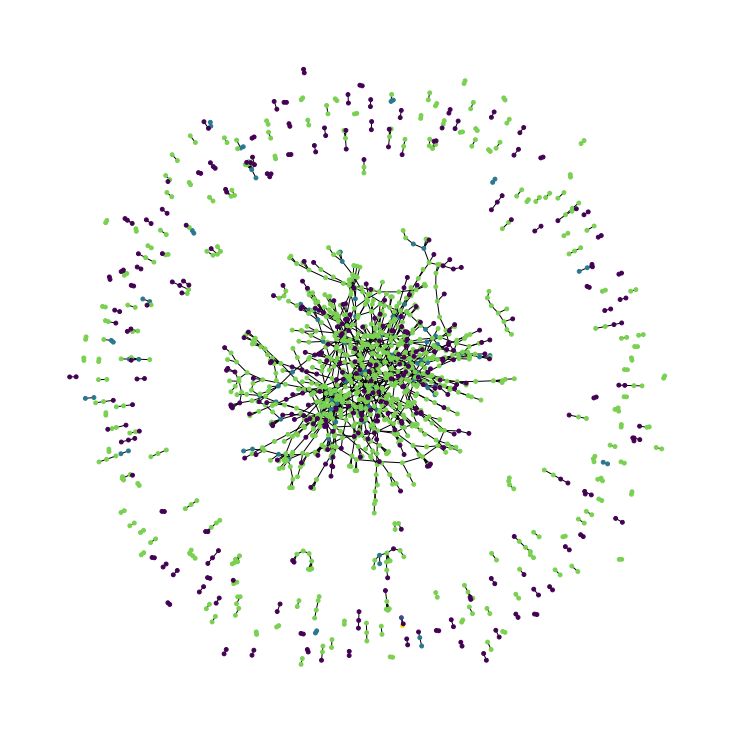

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
colors = nodes["covid_group"].tolist()
cora_graph = nx.from_pandas_edgelist(edges.sample(n=1500))
subjects = list(nodes[nodes["id"].isin(list(cora_graph.nodes))]["covid_group"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)


In [24]:
import numpy as np

train_data, test_data = [], []

for _, group_data in nodes.groupby("covid_group"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (2685, 8)
Test data shape: (2750, 8)


In [25]:
import tensorflow as tf

def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(tf.keras.layers.BatchNormalization())
        fnn_layers.append(tf.keras.layers.Dropout(dropout_rate))
        fnn_layers.append(tf.keras.layers.Dense(units, activation=tf.nn.gelu))

    return tf.keras.Sequential(fnn_layers, name=name)


feature_names = set(['covid', 'non_covid'])
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["covid_group"]
y_test = test_data["covid_group"]


In [26]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = tf.keras.layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = tf.keras.layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = tf.keras.layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return tf.keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     [(None, 2)]          0                                            
__________________________________________________________________________________________________
ffn_block1 (Sequential)         (None, 32)           1288        input_features[0][0]             
__________________________________________________________________________________________________
ffn_block2 (Sequential)         (None, 32)           2368        ffn_block1[0][0]                 
__________________________________________________________________________________________________
skip_connection2 (Add)          (None, 32)           0           ffn_block1[0][0]                 
                                                                 ffn_block2[0][0]          

In [27]:
history = run_experiment(baseline_model, x_train, y_train)


Epoch 1/300
9/9 [==============================] - 7s 98ms/step - loss: 3.2003 - acc: 0.4039 - val_loss: 0.9344 - val_acc: 0.5310
Epoch 2/300
9/9 [==============================] - 0s 19ms/step - loss: 0.7046 - acc: 0.8297 - val_loss: 0.9036 - val_acc: 0.9454
Epoch 3/300
9/9 [==============================] - 0s 18ms/step - loss: 0.4600 - acc: 0.8321 - val_loss: 1.2015 - val_acc: 0.9454
Epoch 4/300
9/9 [==============================] - 0s 21ms/step - loss: 0.4589 - acc: 0.8306 - val_loss: 0.7783 - val_acc: 0.9454
Epoch 5/300
9/9 [==============================] - 0s 23ms/step - loss: 0.4105 - acc: 0.8449 - val_loss: 0.6782 - val_acc: 0.9454
Epoch 6/300
9/9 [==============================] - 0s 19ms/step - loss: 0.4172 - acc: 0.8330 - val_loss: 0.7049 - val_acc: 0.9454
Epoch 7/300
9/9 [==============================] - 0s 19ms/step - loss: 0.3813 - acc: 0.8536 - val_loss: 0.5951 - val_acc: 0.9454
Epoch 8/300
9/9 [==============================] - 0s 19ms/step - loss: 0.4153 - acc: 0.83

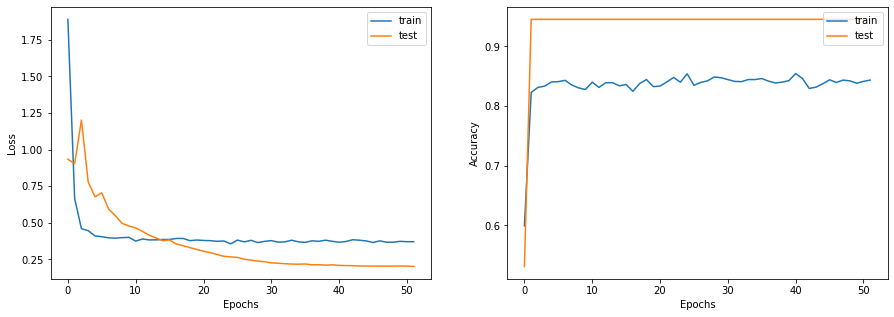

In [28]:
display_learning_curves(history)


In [29]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")


Test accuracy: 94.18%


# Build a Graph Neural Network Model

In [30]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = edges[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    nodes.sort_values("id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)


Edges shape: (2, 214824)
Nodes shape: (5435, 2)


In [31]:
class GraphConvLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = tf.keras.layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = tf.keras.layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [33]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))
gnn_model.summary()


GNN output shape: tf.Tensor(
[[ 0.00679018 -0.00172867  0.04795663 -0.09377136 -0.20835173 -0.06394574]
 [ 0.00679018 -0.00172848  0.04795738 -0.09377083 -0.20835257 -0.06394404]
 [ 0.00678973 -0.00172509  0.04795714 -0.09377068 -0.20835531 -0.06394029]], shape=(3, 6), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess (Sequential)      (5435, 32)                1288      
_________________________________________________________________
graph_conv1 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
graph_conv2 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
postprocess (Sequential)     (5435, 32)                2368      
_________________________________________________________________
logits (Dense)               multipl

In [36]:
x_train = train_data.id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train.to_numpy())


Epoch 1/300


NotImplementedError: in user code:

    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:757 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:496 minimize
        grads_and_vars = self._compute_gradients(
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:548 _compute_gradients
        grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:441 _get_gradients
        grads = tape.gradient(loss, var_list, grad_loss)
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\eager\backprop.py:1080 gradient
        flat_grad = imperative_grad.imperative_grad(
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\eager\imperative_grad.py:71 imperative_grad
        return pywrap_tfe.TFE_Py_TapeGradient(
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\eager\backprop.py:162 _gradient_function
        return grad_fn(mock_op, *out_grads)
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:473 _UnsortedSegmentSumGrad
        return _GatherDropNegatives(grad, op.inputs[1])[0], None, None
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:439 _GatherDropNegatives
        array_ops.ones([array_ops.rank(gathered)
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py:3120 ones
        output = _constant_if_small(one, shape, dtype, name)
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py:2804 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:5 prod
        
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3051 prod
        return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    C:\Users\AndreaHrelja\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:852 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (gradient_tape/gnn_model/graph_conv2/sub:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


In [39]:
display_learning_curves(history)


numpy.ndarray

In [ ]:
x_test = test_data.id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")


In [ ]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")


new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = tf.keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

In [ ]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (edges) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_edges = []
for group_idx, group in nodes.groupby("covid_group"):
    group_nodes = list(group.id)
    # Select random x nodes specific subject.
    selected_node_indices1 = np.random.choice(group_nodes, 5)
    # Select random y nodes from any subject (where y < x).
    selected_node_indices2 = np.random.choice(list(nodes.id), 2)
    # Merge the selected node indices.
    selected_node_indices = np.concatenate(
        [selected_node_indices1, selected_node_indices2], axis=0
    )
    # Create edges between a citing node idx and the selected cited nodes.
    citing_node_indx = new_node_indices[group_idx]
    for cited_node_idx in selected_node_indices:
        new_edges.append([citing_node_indx, cited_node_idx])

new_edges = np.array(new_edges).T
new_edges = np.concatenate([edges, new_edges], axis=1)


In [ ]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = tf.keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)
